In [ ]:
!gdown --id 1ixh-tv-IKMdNjpoINbILJKGRNwcfH5Tj

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1ixh-tv-IKMdNjpoINbILJKGRNwcfH5Tj 



In [ ]:
!unzip PageSegData

unzip:  cannot find or open PageSegData, PageSegData.zip or PageSegData.ZIP.


In [ ]:
pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.4 MB/s 


In [ ]:
import os
import random
import tensorflow as tf
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

#import thu vien semegtation models
from segmentation_models.metrics import iou_score,FScore
from segmentation_models import Unet
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
#variable define
datapath = '/content/drive/MyDrive/PageSegData/PageSegData'
w,h = 512,512
batch_size=16


In [ ]:
# BACKBONE = "resnet34"
# preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
#Importing required libraries.
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
#from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Conv2DTranspose,Input,Add,UpSampling2D,Dropout,concatenate
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
import random

image_list=os.listdir('/content/drive/MyDrive/PageSegData/PageSegData/PageImg/')
image_list=[filename.split(".")[0]for filename in image_list]

def visualize(img,seg_img):
    """
    Visualizes image
    """
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1,2,2)
    plt.imshow(seg_img,cmap='gray')
    plt.title('Segmented Image')
    plt.show()
    
def get_segmented_img(img,n_classes):
    """
    Loads in the segmented image and create suitable segmentation label.
    """
    seg_labels=np.zeros((512,512,1))
    img=cv2.resize(img,(512,512))
    img=img[:,:,0]
    cl_list=[0,24]

    
    seg_labels[:,:,0]=(img!=0).astype(int)


    return seg_labels
def preprocess_img(img):
    img=cv2.resize(img,(512,512))
    return img

def batch_generator(filelist,n_classes,batch_size):
  while True:
    X=[]
    Y=[]
    for i in range(batch_size):
      fn=random.choice(filelist)
      img=cv2.imread(f'/content/drive/MyDrive/PageSegData/PageSegData/PageImg/{fn}.JPG',0)
      ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
      img=cv2.resize(img,(512,512))
      img=np.expand_dims(img,axis=-1)
      #img = np.stack((img,)*3, axis=-1)
      img=img/255

      seg=cv2.imread(f'/content/drive/MyDrive/PageSegData/PageSegData/PageSeg/{fn}_mask.png',1)
      seg=get_segmented_img(seg,n_classes)

      X.append(img)
      Y.append(seg)
    yield np.array(X),np.array(Y)

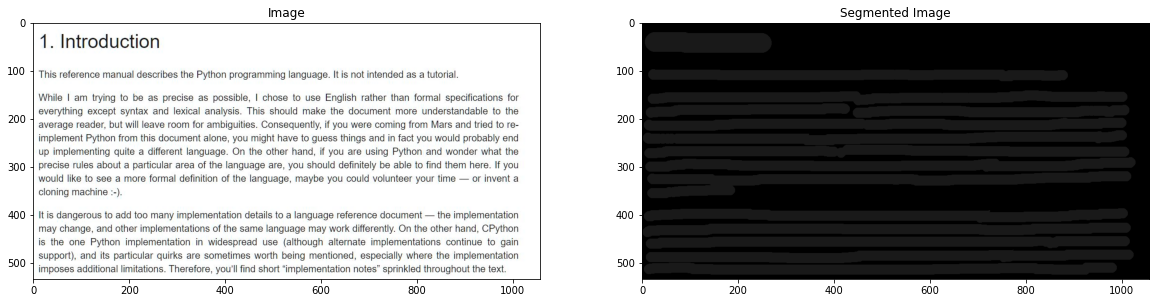

In [ ]:
img=cv2.imread('/content/drive/MyDrive/PageSegData/PageSegData/PageImg/'+image_list[0]+'.JPG',1)
seg=cv2.imread('/content/drive/MyDrive/PageSegData/PageSegData/PageSeg/'+image_list[0]+'_mask.png',1)

visualize(img,seg)

In [ ]:
random.shuffle(image_list)
file_train=image_list[0:int(0.75*len(image_list))]
file_test=image_list[int(0.75*len(image_list)):]

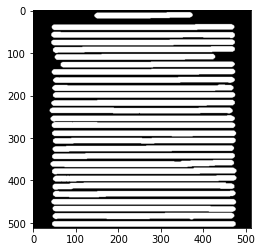

In [ ]:
img,seg=next(batch_generator(file_train,2,1))
plt.imshow(np.squeeze(seg[:,:,:,0],axis=0),cmap='gray')

In [ ]:
def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [ ]:
from scipy import optimize
#khoi tao model
opt = tf.keras.optimizers.Adam(0.001)
model= unet()
model.summary()
loss1= sm.losses.categorical_focal_dice_loss
model.compile(optimizer=opt,loss=loss1,metrics=[iou_score,FScore()])

#train model
is_train = False
if is_train:
  from keras.callbacks import ModelCheckpoint
  filepath='checkpoint.hdf5'
  callback=ModelCheckpoint(filepath,monitor='val_iou_score',verbose = 1, save_best_only=True,mode='max')
  model.fit_generator(batch_generator(file_train,2,2),epochs=5,steps_per_epoch=1000,validation_data=batch_generator(file_test,2,2),
                    validation_steps=400,callbacks=[callback],shuffle=1)

else:
  model.load_weights('checkpoint.hdf5')
  


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 512, 512, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 512, 512, 64  36928       ['conv2d_24[0][0]']              
                                )                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 conv2d_46 (Conv2D)             (None, 512, 512, 2)  1154        ['conv2d_45[0][0]']              
                                                                                                  
 conv2d_47 (Conv2D)             (None, 512, 512, 1)  3           ['conv2d_46[0][0]']              
                                                                                                  
Total params: 31,031,685
Trainable params: 31,031,685
Non-trainable params: 0
__________________________________________________________________________________________________


OSError: ignored

In [ ]:
import seaborn as sns
img=cv2.imread(f'/content/image.jpg',0)
ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
img=cv2.resize(img,(512,512))
img= np.expand_dims(img,axis=-1)

1/1 [==============================] - 4s 4s/step


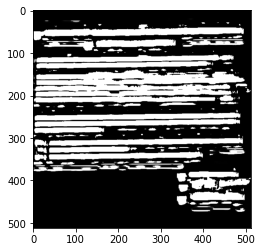

In [ ]:
img=np.expand_dims(img,axis=0)
pred=model.predict(img)
pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)
plt.imshow(pred,cmap='gray')

In [ ]:
plt.imsave('test_img_mask.JPG',pred)

In [ ]:
coordinates=[]

In [ ]:
import cv2
img = cv2.imread('/content/imager_mask.png',0) 
cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
ori_img=cv2.imread('/content/imager.jpg')
ori_img=cv2.resize(ori_img,(512,512))
contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    # draw a white rectangle to visualize the bounding rect
    cv2.rectangle(ori_img, (x, y), (x+w,y+h), 255, 1)
    coordinates.append([x,y,(x+w),(y+h)])

#cv2.drawContours(img, contours, -1, (255, 255, 0), 1)

cv2.imwrite("output.png",ori_img)

True